In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

df_train = pd.read_csv(r'D:\university\DataMining\Ασκηση 2\data_train.csv',low_memory=False)
df_test = pd.read_csv(r'D:\university\DataMining\Ασκηση 2\data_test.csv',low_memory=False)




def rmse(x, x_exp):
    return sqrt(mean_squared_error(x, x_exp))

In [2]:

user_mean_ratings = df_train.groupby('uid')['rating'].mean().round(2)



item_mean_ratings = df_train.groupby('mid')['rating'].mean().round(2)
mean_ratings = df_train['rating'].mean().round(2)

df_test['uid_prediction'] = df_test['uid'].map(user_mean_ratings)
df_test['mid_prediction'] = df_test['mid'].map(item_mean_ratings)
mean_ratings = df_train['rating'].mean().round(2)

df_test['uid_prediction'] = df_test['uid_prediction'].fillna(mean_ratings)
df_test['mid_prediction'] = df_test['mid_prediction'].fillna(mean_ratings)

rmse_ua = rmse(df_test['rating'], df_test['uid_prediction'])
print("User Average RMSE")
print(rmse_ua)
print('\n')
print("Item Average RMSE")
rmse_ui = rmse(df_test['rating'], df_test['mid_prediction'])
print(rmse_ui)

User Average RMSE
0.9612571092064808


Item Average RMSE
0.9859898731731478


1: RMSE=3.1693434551434927
2: RMSE=3.071901440495547
3: RMSE=3.0101179426795217
4: RMSE=2.98038810148478
5: RMSE=2.961302227478819
6: RMSE=2.9423792575282115
7: RMSE=2.922124565762294
8: RMSE=2.923096676551995
9: RMSE=2.9179110049709003
10: RMSE=2.9218828099108345
11: RMSE=2.9156093614211747
12: RMSE=2.922590847636153
13: RMSE=2.91590379622609
14: RMSE=2.910265019186925
15: RMSE=2.9086518238899215
16: RMSE=2.9171786276053786
17: RMSE=2.9227604208920575
18: RMSE=2.927081837254966
19: RMSE=2.9327450269169972
20: RMSE=2.935963705157532


Best error=2.9086518238899215


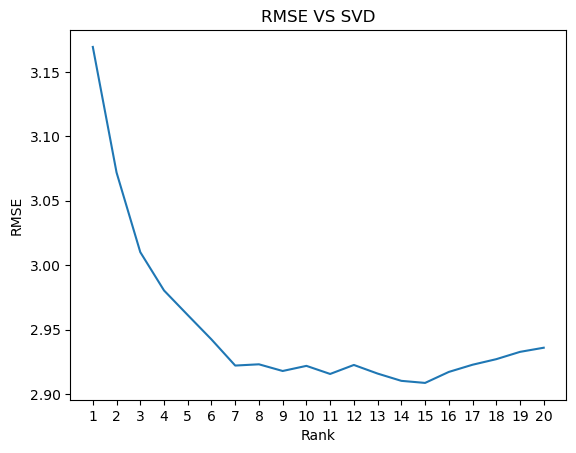

In [3]:


import scipy.sparse as sp_sparse
import scipy.sparse.linalg as sp_linalg
import matplotlib.pyplot as plt


N = df_train['uid'].max()+1
M = df_train['mid'].max()+1

R = sp_sparse.csr_matrix((df_train['rating'].values, (df_train['uid'].values, df_train['mid'].values)),
    shape=(N, M)
)


k=20
U,s,V = sp_linalg.svds(R, k)

U = U[:, ::-1]
s = s[::-1]
Vt = V[::-1, :]



array_k=[]
array_rmse=[]
for i in range(1,k+1):
    Ui = U[:, :i]
    Si = s[:i]
    Vti = Vt[:i,:]
    
    U1 = Ui[df_test['uid'].values] * Si
    V1 = Vti[:, df_test['mid'].values].T
    prediction = np.sum(U1*V1,axis=1)
    prediction = np.clip(prediction, 0,5)
    
    rmsei = rmse(df_test['rating'], prediction)
    array_k.append(i)
    array_rmse.append(rmsei)
    print(f"{i}: RMSE={rmsei}")


min_rmse = min(array_rmse)
print("\n")
print(f"Best error={min_rmse}")        
plt.plot(array_k,array_rmse)
plt.title("RMSE VS SVD")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.xticks(array_k) 

plt.show()

In [4]:


def user_mean(R,u):
    
    user_u = R[u,:]
    
    user_u_ratings = user_u.data
    
    u_mean = np.mean(user_u_ratings)
    
   
    return u_mean

    
def item_users(R,m):
    
    movie_m = R[: , m]
    
    users_for_m = movie_m.nonzero()[0]
    
    return users_for_m


def similar_users(R,u,m_users,k):
    
    user_u = R[u,:]
    
    m_ids = R[m_users, :] 
    
    cos_sim = cosine_similarity(user_u,m_ids).flatten()
   
    cos_sim_sorted = cos_sim.argsort()[::-1]
    
    topk = cos_sim_sorted[:k]  
    
    topk_users = m_users[topk]
    topk_cos_sim= cos_sim[topk]
    
    return topk_users,topk_cos_sim



def compute_score(k_ratings,k_similarities):
    
    x1 = np.sum(k_ratings*k_similarities)
    x2 = np.sum(k_similarities)
    
    if x2==0:
        score =0.0
    else:
        score = x1/x2
    return score




k=1, RMSE=1.2266901991872599 , time=12.0673 sec
k=2, RMSE=1.0820995164230311 , time=12.4251 sec
k=3, RMSE=1.0366195697406786 , time=12.2355 sec
k=5, RMSE=0.999909759063901 , time=12.6568 sec
k=10, RMSE=0.9770242959711843 , time=12.4637 sec
k=20, RMSE=0.971204611719259 , time=12.6360 sec
k=30, RMSE=0.9700415923855438 , time=13.1910 sec
k=40, RMSE=0.9706340777197818 , time=12.4116 sec
k=50, RMSE=0.9708238941686649 , time=12.5346 sec
k=60, RMSE=0.9711648299891441 , time=13.0213 sec
k=70, RMSE=0.9710769147259783 , time=12.9648 sec
k=80, RMSE=0.9712225038441031 , time=12.9543 sec
k=90, RMSE=0.9715167226645984 , time=13.0403 sec
k=100, RMSE=0.9717236049874847 , time=12.9299 sec
Total time=177.5348 sec


Best error=0.9700415923855438


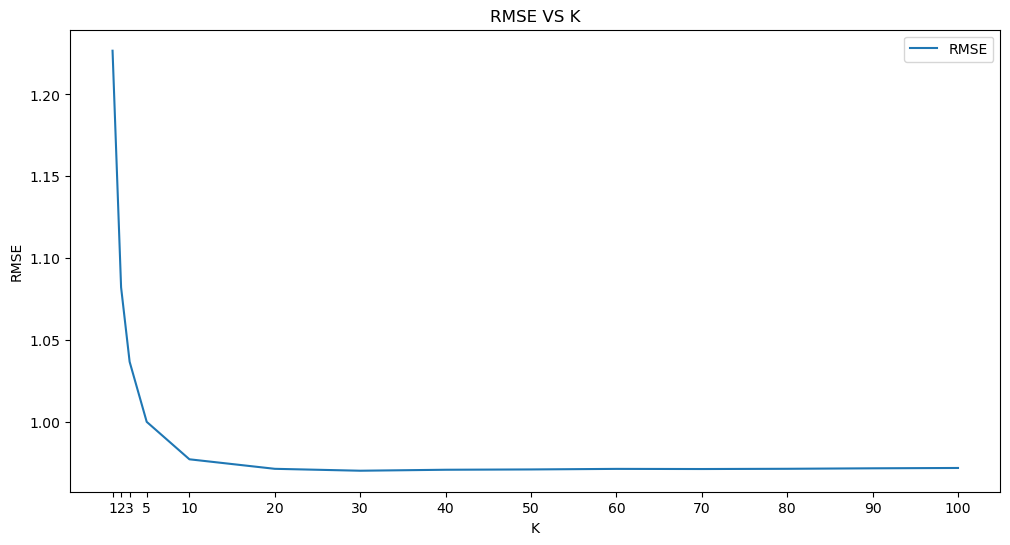

In [5]:
import time


def UCF(u,m,k):
    
    users_for_m = item_users(R,m)
    if users_for_m.size == 0:
        u_mean = user_mean(R,u)
        return u_mean
    
    
    top_users , top_sims = similar_users(R,u,users_for_m,k)
    
    
    k_ratings = R[top_users,m ].toarray().flatten()
    
    score = compute_score(k_ratings,top_sims)
    
    return score
    

    
    
    
K = [1,2,3,5,10,20,30,40,50,60,70,80,90,100]
rmse_res = []


A = df_test[['uid', 'mid']].values
test_pairs = [tuple(row) for row in A]
test_ratings= df_test['rating'].values

time_total_start= time.time()
for i in K:
    
    start = time.time()
    scores=[]
    
    
    for u,m in test_pairs:
        s = UCF(u,m,i)
        scores.append(s)
        
    rmsei = rmse(test_ratings,scores)
    rmse_res.append(rmsei)
    
    end = time.time()
    time_passed = end-start
    
    print(f"k={i}, RMSE={rmsei} , time={time_passed:.4f} sec")
    
time_total_end= time.time()   
time_total = time_total_end-time_total_start
print(f"Total time={time_total:.4f} sec")

min_rmse_ucf = min(rmse_res)
print("\n")
print(f"Best error={min_rmse_ucf}")      

plt.figure(figsize=(12, 6))    
plt.plot(K,rmse_res,label='RMSE')
plt.title("RMSE VS K")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.xticks(K) 
plt.legend()
plt.show()

In [6]:


def UCF_new(u,m,list_k):
    
    users_for_m = item_users(R,m)
    k_max = max(list_k)
    if users_for_m.size == 0:
        u_mean = user_mean(R,u)
        return [u_mean] * len(list_k)
    
    
    
    top_users , top_sims = similar_users(R,u,users_for_m,k_max)
    top_ratings = R[top_users,m ].toarray().flatten()
    
    scores=[]
    for i in list_k:
        k_ratings = top_ratings[:i]
        k_sims = top_sims[:i]
        
        score = compute_score(k_ratings,k_sims)
        
        scores.append(score)
    
    return scores




    
K = [1,2,3,5,10,20,30,40,50,60,70,80,90,100]
rmse_res = []


A = df_test[['uid', 'mid']].values
test_pairs = [tuple(row) for row in A]
test_ratings= df_test['rating'].values



k_scores = {k:[] for k in K}

start_new = time.time()
print("Starting...")

for u,m in test_pairs:
    s= UCF_new(u,m,K)
    
    for idk, sk in enumerate(s):
        k1= K[idk]
        k_scores[k1].append(sk)

        
end_new = time.time()
time_passed_new = end_new-start_new

for i in K:

    score_i = k_scores[i]
    rmsei = rmse(test_ratings,score_i)
    rmse_res.append(rmsei)
    
    print(f"k={i}, RMSE={rmsei}")
    
print(f"Total time: {time_passed_new:.4f} sec")

min_rmse_ucf_new = min(rmse_res)
print("\n")
print(f"Best error={min_rmse_ucf_new}")  

Starting...
k=1, RMSE=1.2266901991872599
k=2, RMSE=1.0820995164230311
k=3, RMSE=1.0366195697406786
k=5, RMSE=0.999909759063901
k=10, RMSE=0.9770242959711843
k=20, RMSE=0.971204611719259
k=30, RMSE=0.9700415923855438
k=40, RMSE=0.9706340777197818
k=50, RMSE=0.9708238941686649
k=60, RMSE=0.9711648299891441
k=70, RMSE=0.9710769147259783
k=80, RMSE=0.9712225038441031
k=90, RMSE=0.9715167226645984
k=100, RMSE=0.9717236049874847
Total time: 13.9563 sec


Best error=0.9700415923855438





|Αλγόριθμος | Best RMSE |
| :--- | :--- |
|User Average | 0.9612571092064808|
|Item Average | 0.9859898731731478|
|SVD | 2.9086518238899206|
|UCF | 0.9700415923855438|


Παρατηρούμε ότι στα συγκεκριμένα δεδομένα, ο αλγόριθμος για το User Average αποδείχθηκε ο πιο αποδοτικός, καθώς δίνει καλύτερο error ακόμα και από τον UCF.Αυτό συμβαίνει ίσως επειδή οι συγκεκριμένοι χρήστες είναι πιο "συνεπείς" στις βαθμολογίες τους, κάτι που καθιστά πιο εύκολο να προβλεφθούν καλύτερα με τον μέσο όρο τους. 

Κάτι παρόμοιο παρατηρείται και στον αλγόριθμο για το Item Average, που ακολουθεί την ίδια διαδικασία , αλλά για τις ταινίες και όχι για τους χρήστες. 

Ο UCF μας δίνει ένα rmse πολύ κοντά σε εκείνο του User Average, της καλύτερης δηλαδή τιμής, πράγμα που σημαίνει ότι η διαδικασία εύρεσης του error χρησιμοποιώντας πληροφορία απο τους πιο όμοιους χρήστες είναι αρκετά αποδοτική. 'Ισως λόγω της αραιότητας του πίνακα δε κατάφερε να ξεπεράσει και τον User Average.

Τέλος, ο αλγόριθμος για το SVD αποδείχθηκε με διαφορά ο χειρότερος. Αυτό ίσως συμβαίνει διότι υπολογίζει όλους τους πίνακες, θεωρώντας τα μηδενικά (μη βαθμολογημένες ταινίες) ως πραγματικές βαθμολογίες, αλλοιώνοντας έτσι την πρόβλεψη.
